# Time Series Forecasting Model Evaluation

### Imports

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np

from constants import START_DATE, WINDOW_SIZE, TRAIN_TEST_RATIO
from helpers import *
from abstract import ForecastingMethod
from linear_regression import LinearRegression
from pqc import PQC
from neural_network import NeuralNetwork

2025-04-04 22:12:33.644732: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training & Test Data Preparation

In [2]:
# Preprocess the data: apply normalization and scaling like the paper does
new_filepath, min_value, max_value, initial_value = (
    ForecastingMethod.preprocess_data(
        filepath="../data/paper-data.csv",
        difference=False,
        scale_to_range=True,
        training_data_cutoff=TRAIN_TEST_RATIO,
    )
)

# Load the data
X, y = ForecastingMethod.load_data(
    filepath=new_filepath, windows_size=WINDOW_SIZE
)
train_test_split_index = int(len(X) * TRAIN_TEST_RATIO)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=(1 - TRAIN_TEST_RATIO), shuffle=False
)

In [3]:
# Post process original data (for graphs only)
y_scaled = ForecastingMethod.post_process_data(
    y, min_value, max_value, initial_value, scale_to_range=True
)
X_scaled = ForecastingMethod.post_process_data(
    X, min_value, max_value, initial_value, scale_to_range=True
)
ORIG_SCALED = np.concatenate((X_scaled[0:WINDOW_SIZE, 0], y_scaled))
GRAPH_SPLIT_INDEX = train_test_split_index + WINDOW_SIZE

# Linear Regression

### Training - Model Creation & Weight Finding

In [4]:
models = [
    (
        "Linear Regression",
        LinearRegression(
            regularization=None, fit_intercept=False, cv_folds=None
        ),
    ),
    (
        "Linear Regression with Y-Intercept",
        LinearRegression(
            regularization=None, fit_intercept=True, cv_folds=None
        ),
    ),
    (
        "L1 Regularized Linear Regression",
        LinearRegression(
            regularization="l1",
            fit_intercept=True,
            cv_folds=5,
            alphas=[0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 1, 5, 10, 100],
        ),
    ),
    (
        "L2 Regularized Linear Regression",
        LinearRegression(
            regularization="l2",
            fit_intercept=True,
            cv_folds=5,
            alphas=[
                0.0001,
                0.001,
                0.01,
                0.1,
                0.3,
                0.5,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                10,
                100,
            ],
        ),
    ),
]

for name, model in models:
    model.train(X_train, y_train)

### Prediction - Timeseries Forecasting & Evaluation

In [5]:
for name, model in models:
    print("")
    print("#" * 50)
    print(name)
    print("#" * 50)
    print(f"Training Loss (MSE): {model.score(X_train, y_train)}")
    print(f"Testing Loss (MSE): {model.score(X_test, y_test)}")
    if "alpha" in model.model.get_params():
        print(f"Best Alpha: {model.model.get_params()["alpha"]}")


##################################################
Linear Regression
##################################################
Training Loss (MSE): 0.004362187562586465
Testing Loss (MSE): 0.039515172019350626

##################################################
Linear Regression with Y-Intercept
##################################################
Training Loss (MSE): 0.0035992407468405673
Testing Loss (MSE): 0.03680124805442622

##################################################
L1 Regularized Linear Regression
##################################################
Training Loss (MSE): 0.008584740568222893
Testing Loss (MSE): 0.029688163630002172
Best Alpha: 0.01

##################################################
L2 Regularized Linear Regression
##################################################
Training Loss (MSE): 0.005564872791968336
Testing Loss (MSE): 0.029718253368471066
Best Alpha: 0.3


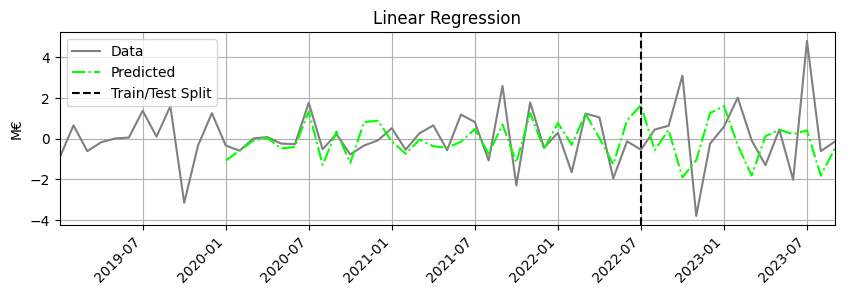

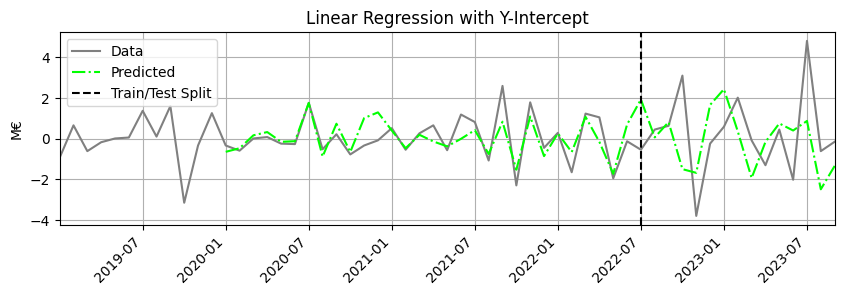

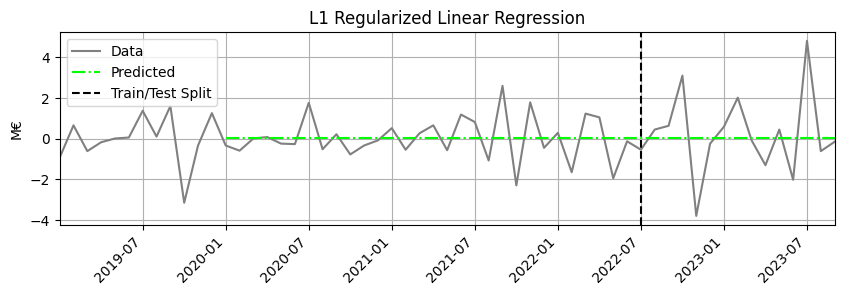

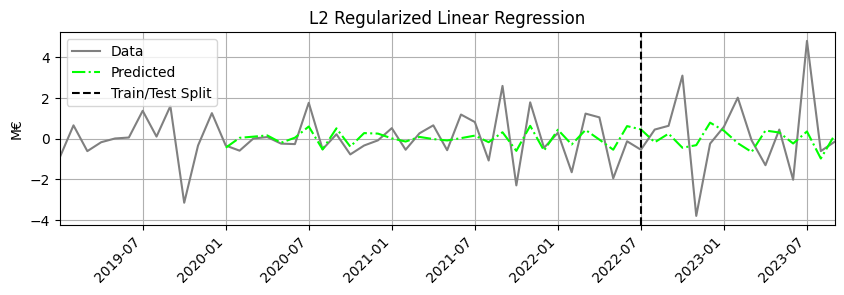

In [6]:
for name, model in models:
    # Post process predictions
    X_pred_scaled = ForecastingMethod.post_process_data(
        model.predict(X),
        min_value,
        max_value,
        initial_value,
        scale_to_range=True,
    )

    plot_sales_growth(
        START_DATE,
        ORIG_SCALED,
        X_pred_scaled,
        pred_linestyle="-.",
        pred_color="lime",
        title=name,
        train_test_split=GRAPH_SPLIT_INDEX,
        window_size=WINDOW_SIZE,
    )

# PQC

### Training - Model Creation & Weight Finding

In [7]:
N_WIRES = 12
N_LAYERS = 2

# Create L-BFGS-B model
pqc_model_lbfgsb = PQC(
    n_wires=N_WIRES, n_layers=N_LAYERS, optimizer="L-BFGS-B"
)
# Create the COBYLA model
pqc_model_cobyla = PQC(n_wires=N_WIRES, n_layers=N_LAYERS, optimizer="COBYLA")

# load weights - since training takes 30+ minutes
pqc_model_lbfgsb.load_weights("../models/pqc_lbfgsb.npy")
pqc_model_cobyla.load_weights("../models/pqc_cobyla.npy")

True

### Circuit Diagram

(<Figure size 1100x1300 with 1 Axes>, <Axes: >)

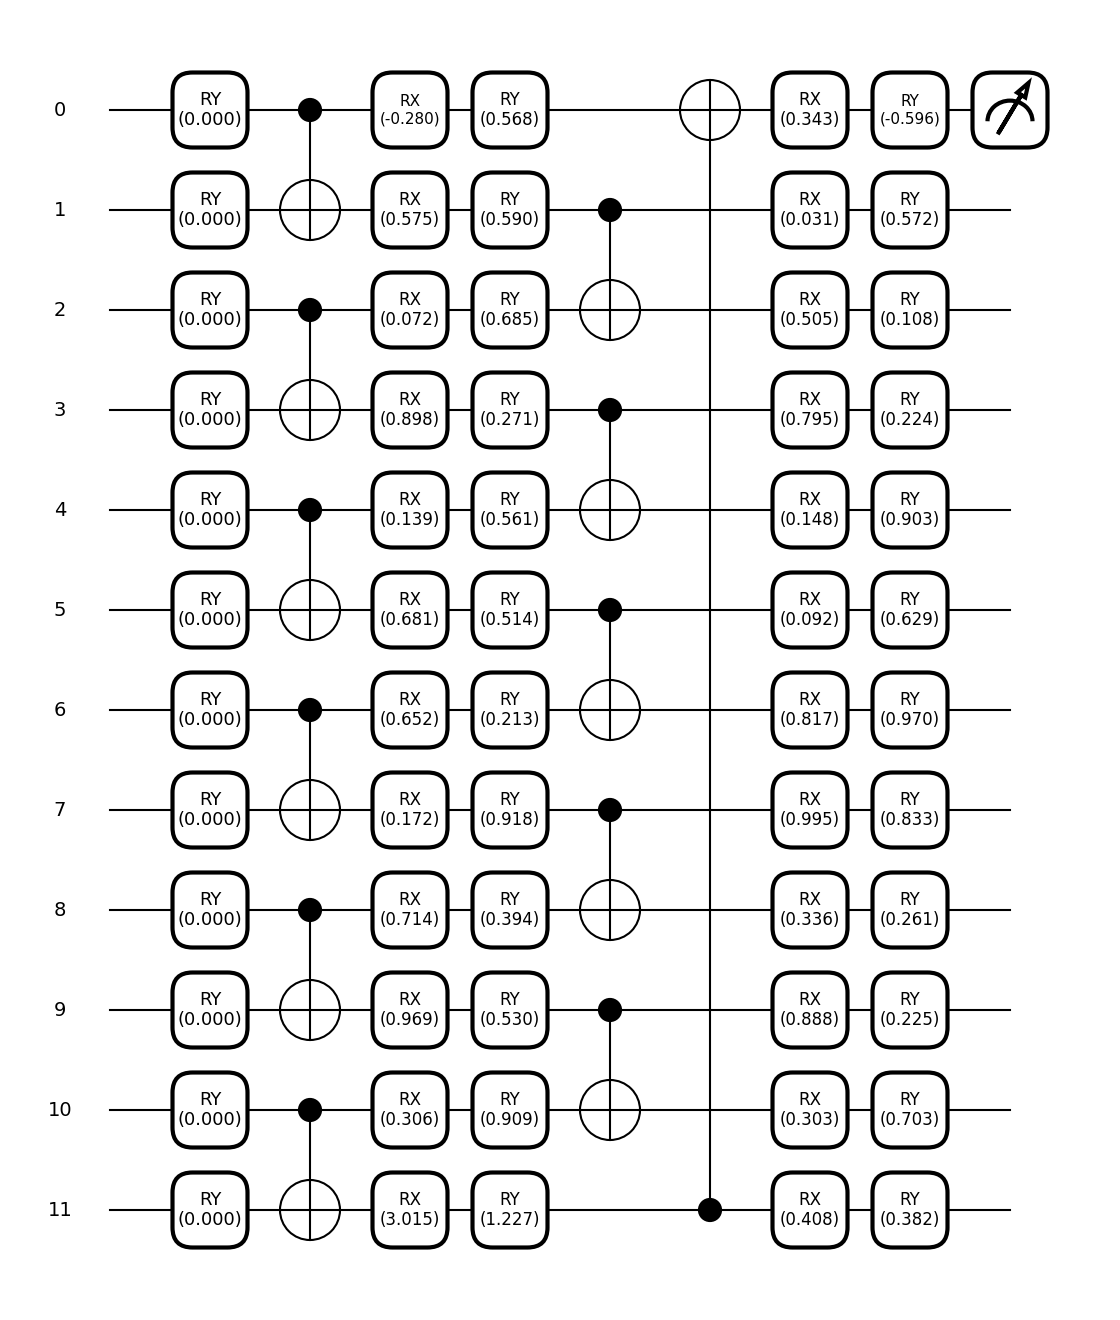

In [8]:
pqc_model_lbfgsb.draw_circuit()

### Prediction - Timeseries Forecasting & Evaluation

In [9]:
# Predict the dataset as whole
predictions_L = pqc_model_lbfgsb.predict(X)
predictions_C = pqc_model_cobyla.predict(X)

# Compute the training loss with processed data
train_mse_L = np.mean((predictions_L[:train_test_split_index] - y_train) ** 2)
train_mse_C = np.mean((predictions_C[:train_test_split_index] - y_train) ** 2)

# Compute testing loss
test_mse_L = np.mean((predictions_L[train_test_split_index:] - y_test) ** 2)
test_mse_C = np.mean((predictions_C[train_test_split_index:] - y_test) ** 2)

print("#" * 50)
print("PQC with L-BFGS-B Optimizer")
print("#" * 50)
print(f"Training Loss (MSE): {train_mse_L}")
print(f"Test Loss (MSE): {test_mse_L}")
print("")
print("#" * 50)
print("PQC with COBYLA Optimizer")
print("#" * 50)
print(f"Training Loss (MSE): {train_mse_C}")
print(f"Test Loss (MSE): {test_mse_C}")

##################################################
PQC with L-BFGS-B Optimizer
##################################################
Training Loss (MSE): 0.006030988910997584
Test Loss (MSE): 0.02883729135523162

##################################################
PQC with COBYLA Optimizer
##################################################
Training Loss (MSE): 0.006626475568226875
Test Loss (MSE): 0.024849822173311966


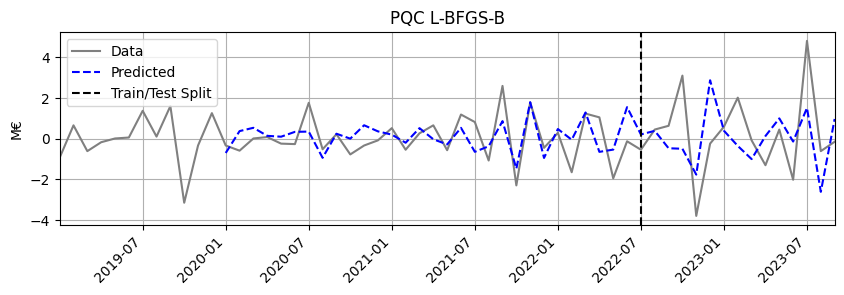

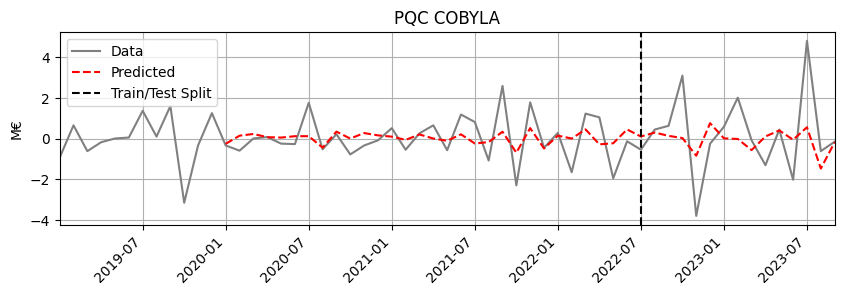

In [10]:
# Post process predictions
predictions_L_scaled = ForecastingMethod.post_process_data(
    predictions_L, min_value, max_value, initial_value, scale_to_range=True
)
predictions_C_scaled = ForecastingMethod.post_process_data(
    predictions_C, min_value, max_value, initial_value, scale_to_range=True
)

# Plot the results
plot_sales_growth(
    START_DATE,
    ORIG_SCALED,
    predictions_L_scaled,
    pred_linestyle="--",
    pred_color="blue",
    title="PQC L-BFGS-B",
    train_test_split=GRAPH_SPLIT_INDEX,
    window_size=WINDOW_SIZE,
)
plot_sales_growth(
    START_DATE,
    ORIG_SCALED,
    predictions_C_scaled,
    pred_linestyle="--",
    pred_color="red",
    title="PQC COBYLA",
    train_test_split=GRAPH_SPLIT_INDEX,
    window_size=WINDOW_SIZE,
)

# Neural Network

### Training - Model Creation & Weight Finding

In [11]:
nn = NeuralNetwork()
nn.train(X_train, y_train)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0140
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0110
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0121
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0090
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0124
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0086
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0097
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0094
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0093
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0092
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0093
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0062
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0071
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0084
Epoch 16/200
4/4 ━━

### Prediction - Timeseries Forecasting & Evaluation

In [12]:
predictions = nn.predict(X)

train_mse = np.mean((predictions[:train_test_split_index] - y_train) ** 2)
test_mse = np.mean((predictions[train_test_split_index:] - y_test) ** 2)

print(f"Training Loss (MSE): {train_mse}")
print(f"Testing Loss (MSE): {test_mse}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Training Loss (MSE): 7.213444100909274e-06
Testing Loss (MSE): 0.04988700837933995


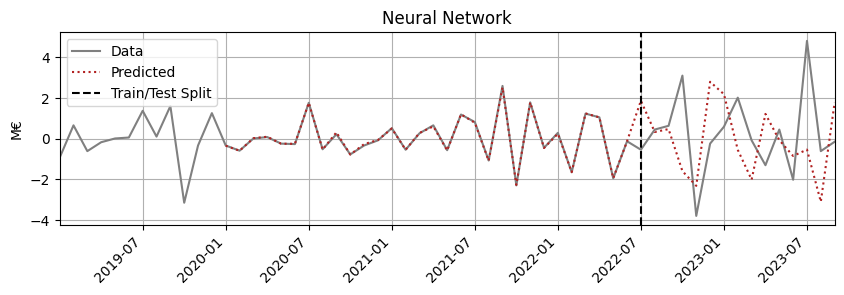

In [13]:
# Post process predictions
X_pred_scaled = ForecastingMethod.post_process_data(
    predictions, min_value, max_value, initial_value, scale_to_range=True
)

plot_sales_growth(
    START_DATE,
    ORIG_SCALED,
    X_pred_scaled,
    pred_linestyle=":",
    pred_color="firebrick",
    title="Neural Network",
    train_test_split=GRAPH_SPLIT_INDEX,
    window_size=WINDOW_SIZE,
)